In [149]:
import pickle, os, glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, minimize

In [150]:
path = "D:/data/SiPM/waveforms/20240502/"
filename_list = ["Bi207_26V_x0_y0_*.pkl",] 
save_str = ["Bi207",]
ov_list = [26,]
data_time = [1, ] ## acquisition time in seconds

In [151]:
ovs_dict = {}
for j,filename in enumerate(filename_list):
    
    curr_files = glob.glob(os.path.join(path, filename))
    
    data_dict = {}

    wfidx = 0
    for cidx, cf in enumerate(curr_files):
        
        with open(cf, 'rb') as fin:
            curr_dict = pickle.load(fin)

            for wf in curr_dict:

                sum_waveform = np.zeros_like(wf['time'])	
                
                ## subtract baseline
                baseline = 2048 

                channel_dict = {}
                for k, ch in enumerate(range(16,-1,-2)):
                    channel_dict[k] = wf[ch] - baseline
                    sum_waveform += (wf[ch] - baseline)

                channel_dict[9] = sum_waveform

                data_dict[wfidx] = channel_dict
                wfidx += 1

    nwaveforms = wfidx
    print("Got %d waveforms"%nwaveforms + " for %d files: "%len(curr_files) + filename)
    data_dict['time'] = wf['time']*1e9

    ovs_dict[ov_list[j]] = {'nwaveforms': nwaveforms, 'data_dict': data_dict}


Got 5659 waveforms for 64 files: Bi207_26V_x0_y0_*.pkl


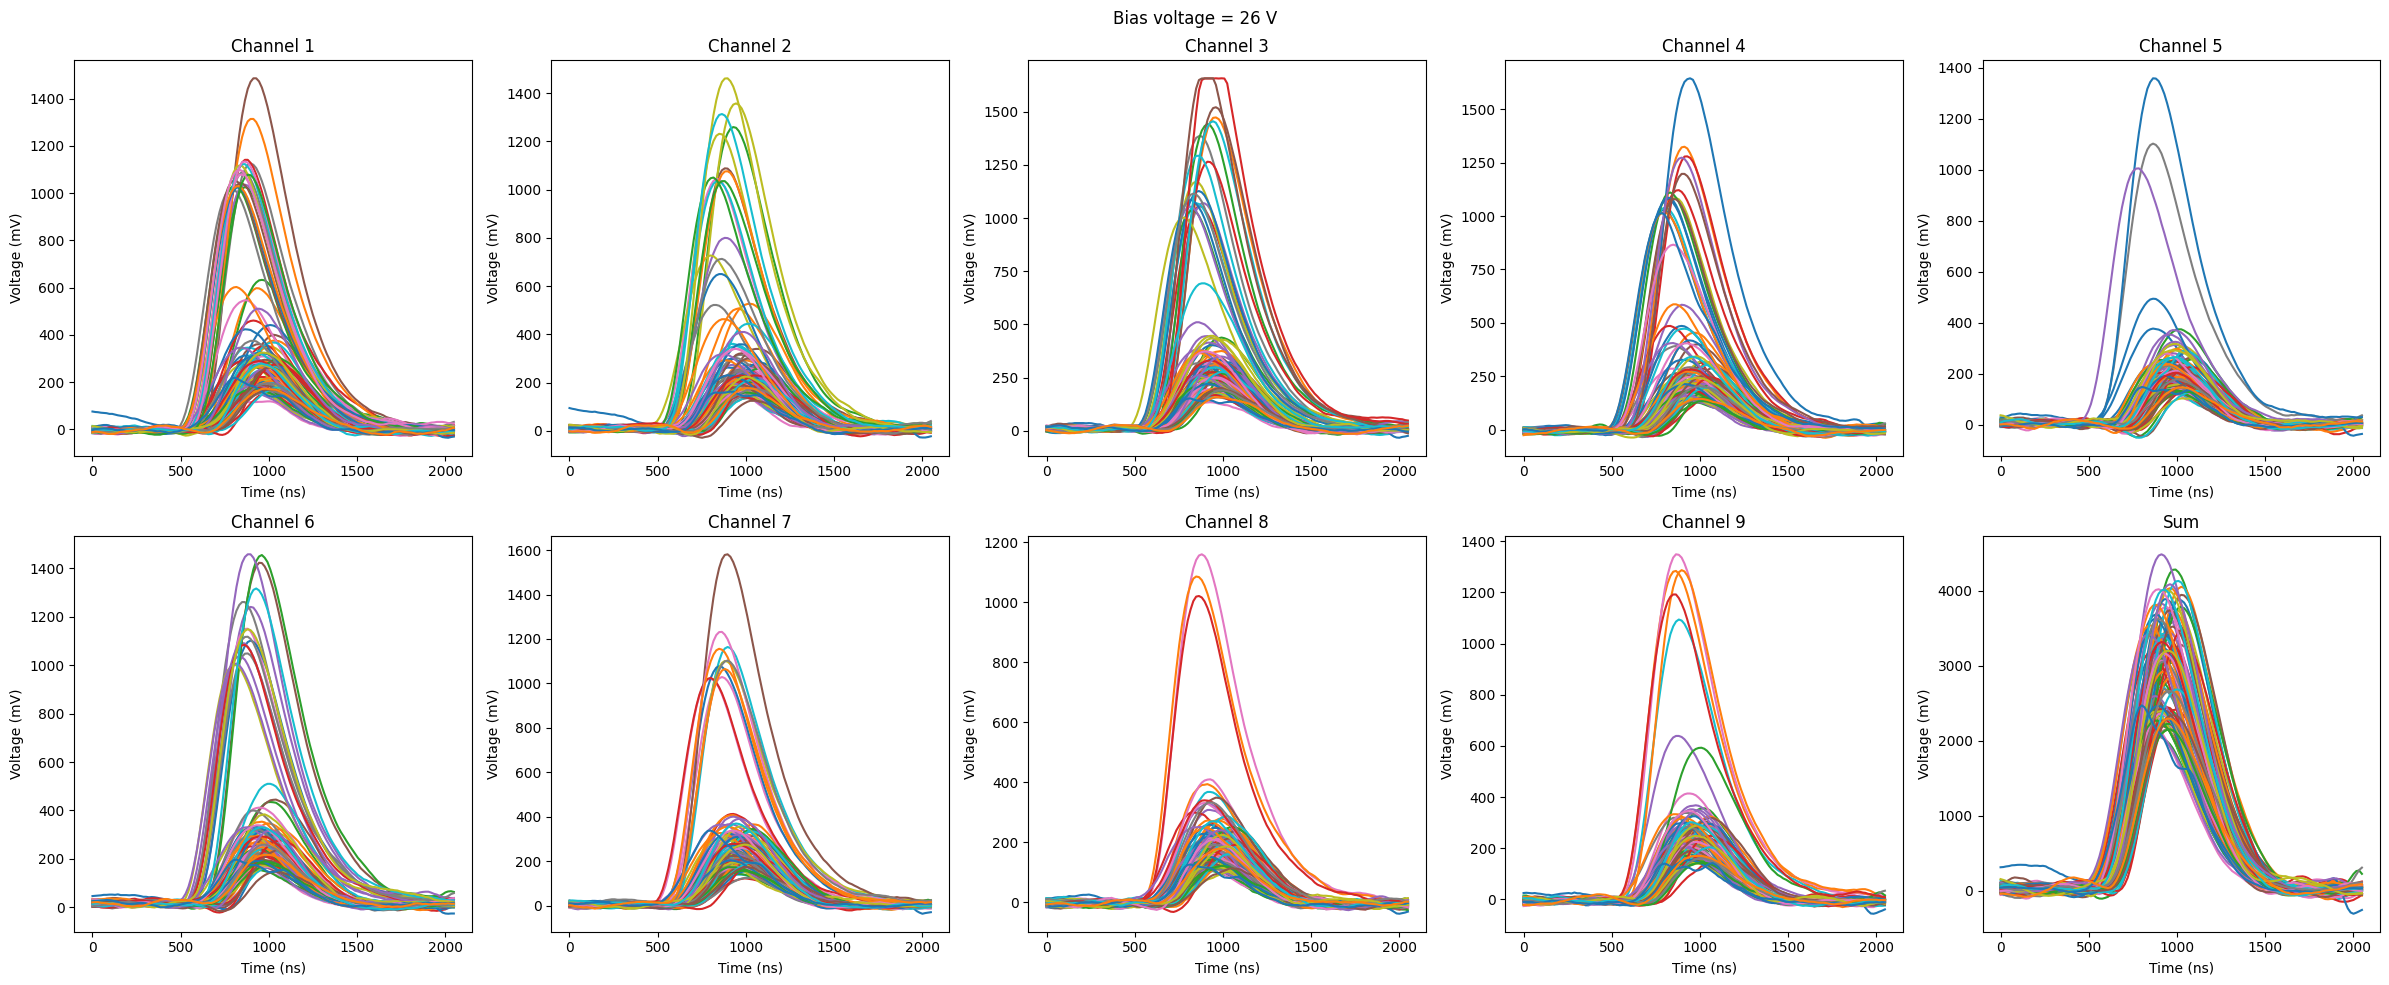

In [152]:
make_plot = True
max_figs = 100

for ov in ov_list:

    nwaveforms = ovs_dict[ov]['nwaveforms']
    data_dict = ovs_dict[ov]['data_dict']

    if(nwaveforms > max_figs):
        downsamp = int(nwaveforms/max_figs)
    else:
        downsamp = 1

    if(make_plot):

        plt.figure(figsize=(24,10))

        for j in range(nwaveforms):
            if(j%downsamp != 0): continue

            for ch in range(10):
                plt.subplot(2,5,ch+1)
                plt.plot(data_dict['time'], data_dict[j][ch])
                plt.xlabel('Time (ns)')
                plt.ylabel('Voltage (mV)')
                if(ch < 9):
                    plt.title("Channel %d"%(ch+1))
                else:
                    plt.title("Sum")

        plt.suptitle("Bias voltage = %s V"%str(ov))
    plt.tight_layout()


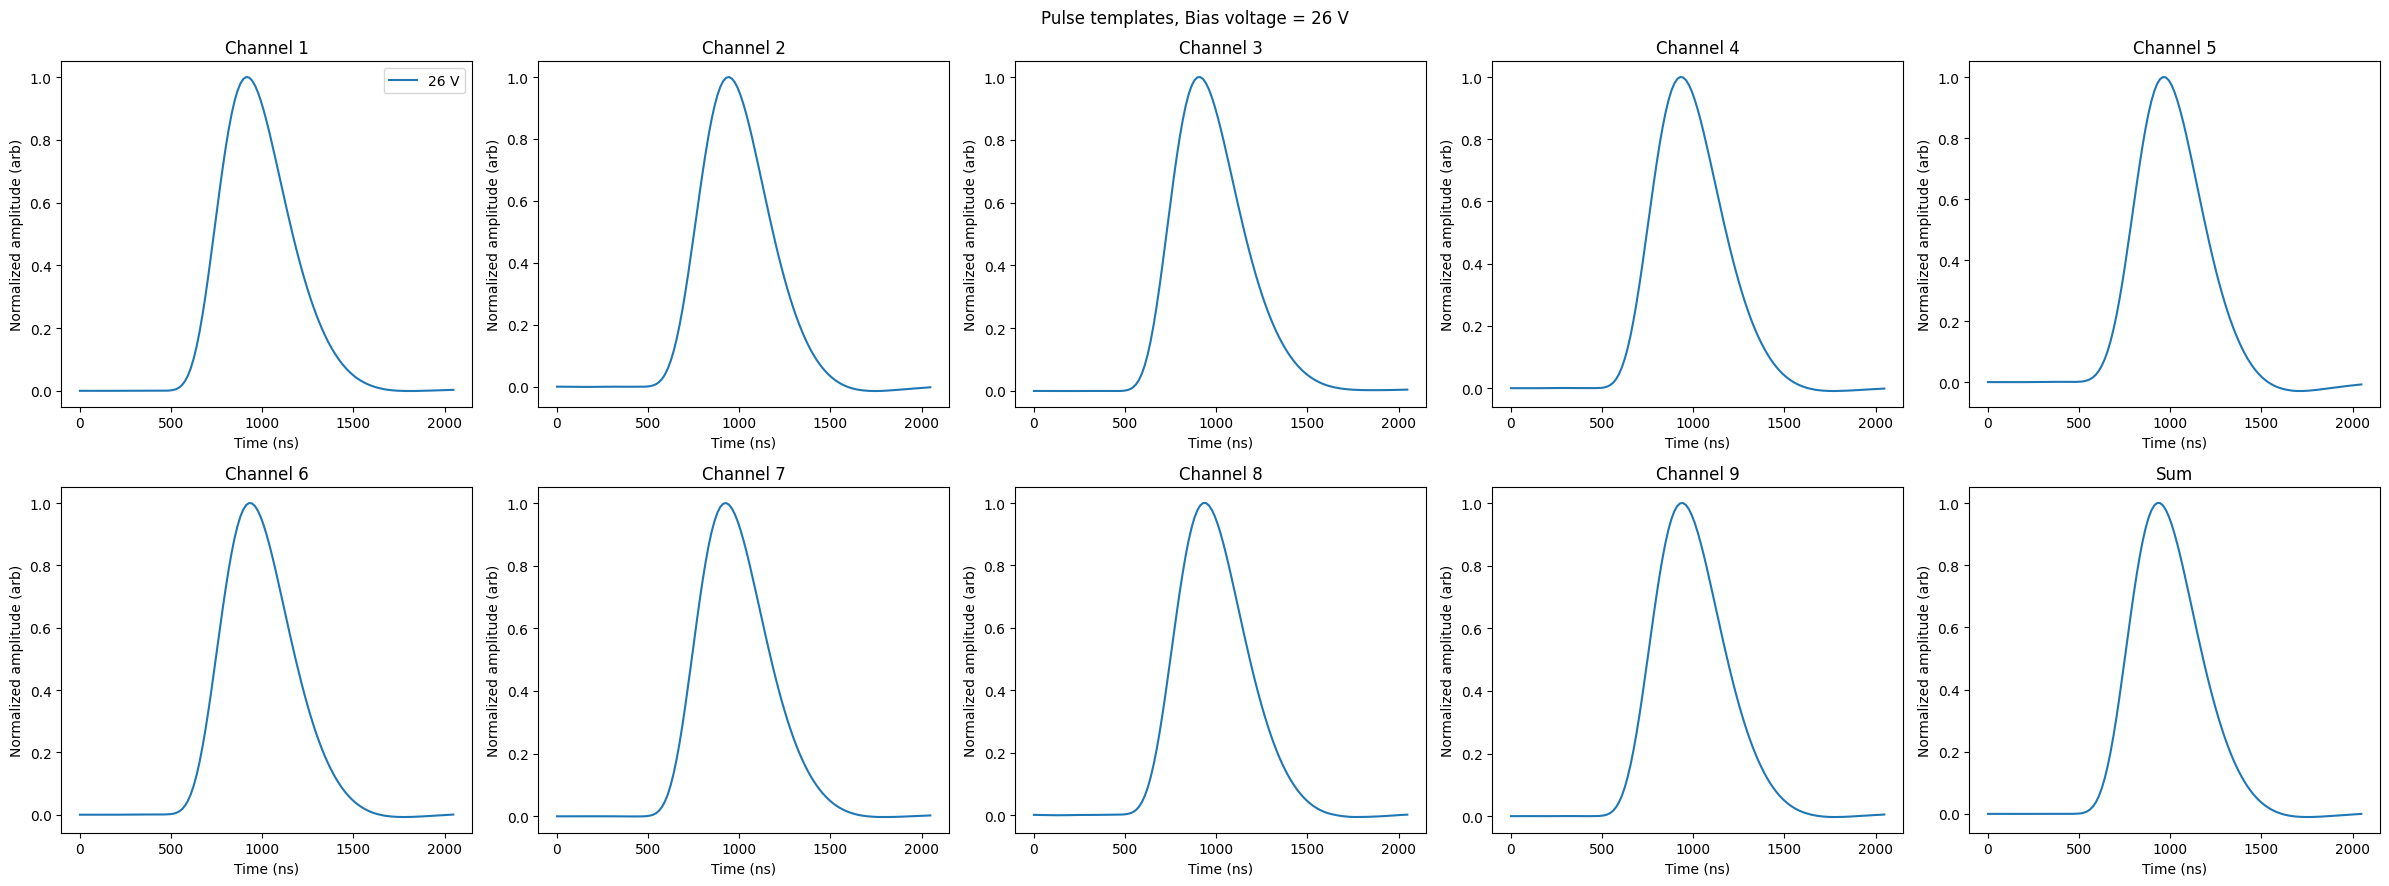

In [153]:
template_ch_dict = {}

min_vals = [200, 1000]

for ov in ov_list:

    plt.figure(figsize=(24,9))

    nwaveforms = ovs_dict[ov]['nwaveforms']
    data_dict = ovs_dict[ov]['data_dict']

    ## make average template
    template_dict = {}
    nwfm = np.zeros(10)
    for ch in range(10):
        template_dict[ch] = np.zeros(len(data_dict['time']))

    for j in range(nwaveforms):

        cdat = data_dict[j]

        for ch in range(10):

            ## throw out bad traces
            min_val = min_vals[0] if ch < 9 else min_vals[1]
            if np.max(cdat[ch]) < min_val:
                continue

            template_dict[ch] += cdat[ch]
            nwfm[ch] += 1

    for ch in range(10):
        plt.subplot(2,5,ch+1)
        template_dict[ch] /= nwfm[ch]
        template_dict[ch] -= np.median(template_dict[ch][:20])
        template_dict[ch] /= np.max(template_dict[ch])

        plt.plot(data_dict['time'], template_dict[ch], label="%s V"%str(ov))
        plt.xlabel('Time (ns)')
        plt.ylabel('Normalized amplitude (arb)')

        if(ch < 9):
            plt.title("Channel %d"%(ch+1))
        else:
            plt.title("Sum")

    template_ch_dict[ov] = template_dict

    plt.suptitle("Pulse templates, Bias voltage = %s V"%str(ov))
    plt.subplot(2,5,1)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [154]:
def gauss(x, A, mu, sig):
    return A*np.exp(-(x-mu)**2/(2*sig**2))

In [155]:
remake_files = True
for oidx, ov in enumerate(ov_list):

    if(remake_files):

        window  = [800, 1300]

        data_dict = ovs_dict[ov]['data_dict']

        mpts = (data_dict['time'] > window[0]) & (data_dict['time'] < window[1])

        recon_amps_max = []   
        recon_amps_fit = []   
          
        for k in data_dict.keys():
            if k == 'time': continue

            cdat_dict = data_dict[k]
            
            channel_max = np.zeros(10)
            channel_fit = np.zeros(10)
            for ch in range(10):

                cdat = cdat_dict[ch]

                fit = np.sum( cdat*template_ch_dict[ov][ch] ) / np.sum(template_ch_dict[ov][ch]**2)

                midx = np.argmax(np.abs(cdat[mpts]))
                max_val = cdat[mpts][midx]
                
                channel_max[ch] = max_val
                channel_fit[ch] = fit
            
            recon_amps_max.append(channel_max)
            recon_amps_fit.append(channel_fit)

        recon_amps_max = np.array(recon_amps_max)
        recon_amps_fit = np.array(recon_amps_fit)

        np.savez( os.path.join(path, "recon_amps_%s_%s.npz"%(save_str[oidx],ov)), recon_amps_max=recon_amps_max, 
                                                                                  recon_amps_fit=recon_amps_fit,
                                                                                  nwaveforms=nwaveforms)

    

In [156]:
def cal_fun(cal_facs, data):
    ## function to sum data multiplied by channel-by-channel calibration factors
    ## cal_facs should be row vector (1x9)
    ## data should be array (nevts x 9)
    summed_data = data @ cal_facs.T
    return np.std(summed_data)/np.median(summed_data) 

In [157]:
## optimize the channel to channel calibration

method_list = ['max', 'fit']

cal_dict_ovs = {}

for oidx, ov in enumerate(ov_list):

    cal_dict = {}
    for method in method_list:

        curr_amps = recon_amps_max if method=='max' else recon_amps_fit

        gpts = curr_amps[:,9] > 200 ## throw out pedestal

        curr_amps = curr_amps[gpts,:9]

        cal_guess = np.ones(9)

        res = minimize(cal_fun, cal_guess, args=curr_amps, method="Nelder-Mead")

        cal_dict[method] = np.ones_like(res.x)

        print("Terminated successfully: ", res.success)
        print("Cal facs for %s: "%method, res.x)
    
    cal_dict_ovs[ov] = cal_dict

Terminated successfully:  True
Cal facs for max:  [1.17696422 0.82640508 1.27273192 0.89999249 0.75305112 0.90810489
 1.22358624 0.69346062 1.07759742]
Terminated successfully:  True
Cal facs for fit:  [1.21021468 0.80410535 1.27533527 0.88757665 0.68679672 0.97511831
 1.27914188 0.73440646 0.9837814 ]


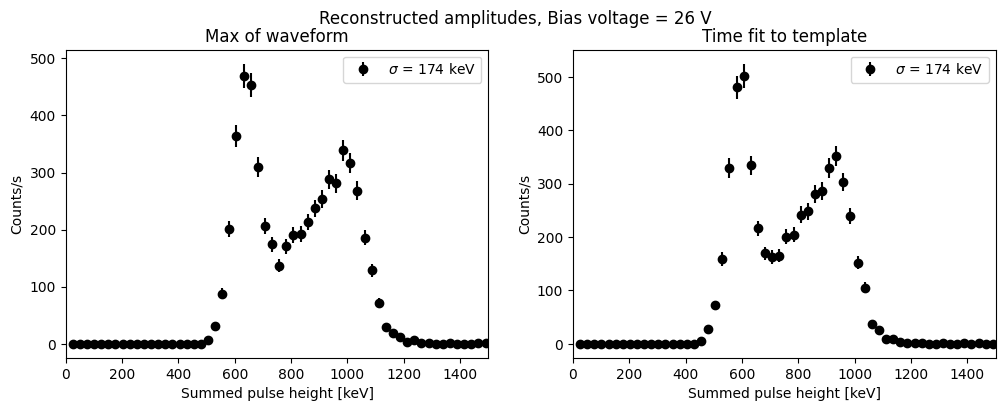

In [158]:
## plot and fit

cal_type_list = ['channel cal']

for oidx, ov in enumerate(ov_list):

    data = np.load( os.path.join(path, "recon_amps_%s_%s.npz"%(save_str[oidx],ov)) )
    recon_amps_max = data['recon_amps_max']
    recon_amps_fit = data['recon_amps_fit']
    nwaveforms = data['nwaveforms']

    plt.figure(figsize=(12, 4))

    for cal_type in cal_type_list:

        bins = np.linspace(0,10000, 100)
        bc = bins[:-1] + np.diff(bins)

        norm = data_time[oidx]

        if(cal_type == 'equal'):
            max_amps = recon_amps_max[:,9]
            fit_amps = recon_amps_fit[:,9]
        else:
            max_amps = recon_amps_max[:,:9] @ cal_dict_ovs[ov]['max']
            fit_amps = recon_amps_fit[:,:9] @ cal_dict_ovs[ov]['fit']

        h_max, be = np.histogram( max_amps, bins=bins )
        h_fit, be = np.histogram( fit_amps, bins=bins )

        fpts = bc > 2000
        errs = np.sqrt(h_max[fpts])
        errs[errs==0] = 1
        spars = [np.max(h_max), np.median(max_amps), np.std(max_amps)]
        gc_max = spars
        #gc_max, _ = curve_fit(gauss, bc[fpts], h_max[fpts], p0=spars, sigma=errs)

        errs = np.sqrt(h_fit[fpts])
        errs[errs==0] = 1
        spars = [np.max(h_fit), np.median(fit_amps), np.std(fit_amps)]
        gc_fit = spars
        #gc_fit, _ = curve_fit(gauss, bc[fpts], h_fit[fpts], p0=spars, sigma=errs)


        #am241_alpha_eng = 5486 ## keV
        eng_cal_fac_max = 0.25 #am241_alpha_eng/np.abs(gc_max[1])
        eng_cal_fac_fit = 0.25 #am241_alpha_eng/np.abs(gc_fit[1])

        if('bkg' in str(ov)): 
            continue

        xx = np.linspace(0, bc[-1], 1000)

        plt.subplot(1,2,1)
        plt.errorbar(bc*eng_cal_fac_max, h_max/norm, yerr=np.sqrt(h_max)/norm, fmt='ko', label=r"$\sigma$ = %.0f keV"%(gc_max[2]*eng_cal_fac_max))
        #plt.gca().set_yscale('log')
        #plt.plot(xx*eng_cal_fac_max, gauss(xx, *gc_max)/norm, 'orange')
        plt.xlim(0,1500)
        plt.xlabel("Summed pulse height [keV]")
        plt.ylabel("Counts/s")
        plt.title("Max of waveform")
        #plt.ylim(0,0.2)
        plt.legend()

        plt.subplot(1,2,2)
        plt.errorbar(bc*eng_cal_fac_fit, h_fit/norm, yerr=np.sqrt(h_fit)/norm, fmt='ko', label=r"$\sigma$ = %.0f keV"%(gc_max[2]*eng_cal_fac_fit))
        #plt.gca().set_yscale('log')
        #plt.plot(xx*eng_cal_fac_fit, gauss(xx, *gc_fit)/norm, 'orange')
        plt.xlabel("Summed pulse height [keV]")
        plt.ylabel("Counts/s")
        plt.xlim(0,1500)
        plt.title("Time fit to template")
        #plt.ylim(0,0.2)
        plt.legend()

        plt.suptitle("Reconstructed amplitudes, Bias voltage = %s V"%str(ov))
    plt.savefig(os.path.join(path, "Am241_resolution_%d.png"%ov))
    plt.show()